## **CROP YIELD PREDICTION USING REGRESSION MODELS**

I have my dataset stored in my Google Drive, and to use it, we must mount the stored folder to the Google Collaborator.

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib


The filepath to the dataset is "/content/drive/My Drive/...." if we have saved it in the folder Mydrive.

In [33]:
filepath = '/content/drive/My Drive/yield_df.csv' #path to the location of file

Loading the data

In [34]:
dataset = pd.read_csv(filepath)

Printing the first 120 data rows and dropping the unnamed column for clean data.

In [35]:
print(dataset.head(120))
# Drop the 'Unnamed: 0' column
dataset= dataset.drop(columns=['Unnamed: 0'])
dataset = dataset.dropna()


     Unnamed: 0     Area         Item  Year  hg/ha_yield  \
0             0  Albania        Maize  1990        36613   
1             1  Albania     Potatoes  1990        66667   
2             2  Albania  Rice, paddy  1990        23333   
3             3  Albania      Sorghum  1990        12500   
4             4  Albania     Soybeans  1990         7000   
..          ...      ...          ...   ...          ...   
115         115  Algeria     Potatoes  1993       111215   
116         116  Algeria  Rice, paddy  1993        23111   
117         117  Algeria      Sorghum  1993        50000   
118         118  Algeria        Wheat  1993         8097   
119         119  Algeria        Maize  1994         4512   

     average_rain_fall_mm_per_year  pesticides_tonnes  avg_temp  
0                           1485.0             121.00     16.37  
1                           1485.0             121.00     16.37  
2                           1485.0             121.00     16.37  
3              

Now, we can obtain further information from the individual column to observe if more cleaning of data is necessary, especially the null column.

In [36]:
print(dataset.info())
print(dataset.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Area                           28242 non-null  object 
 1   Item                           28242 non-null  object 
 2   Year                           28242 non-null  int64  
 3   hg/ha_yield                    28242 non-null  int64  
 4   average_rain_fall_mm_per_year  28242 non-null  float64
 5   pesticides_tonnes              28242 non-null  float64
 6   avg_temp                       28242 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.5+ MB
None
               Year    hg/ha_yield  average_rain_fall_mm_per_year  \
count  28242.000000   28242.000000                    28242.00000   
mean    2001.544296   77053.332094                     1149.05598   
std        7.051905   84956.612897                      709.81215   
min     1

Now I have decided to predict the yield of the crops as my object. So to prepare data for my input, I will drop the yield column and use separate variables x and y for input and output, respectively.

In [37]:
X = dataset.drop(columns=['hg/ha_yield'])  # Dropping hg/ha_field as it is set to be output for us
y = dataset['hg/ha_yield'] #saving output data in a separate variable

Since Area (Country) and Item (Crop) are categorical variables, we'll need to encode them to numerical values for machine learning models. Year column can be used to experiment, but the models performed well when used as a numerical column.

In [38]:
# One-hot encode categorical columns: 'Area' and 'Item'
categorical_cols = ['Area', 'Item', ]
numerical_cols = ['Year', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']

In [39]:
# Preprocessor: scaling numerical columns, one-hot encoding categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

The reason you are seeing 0 for other countries (such as Albania, Algeria, etc.) in the one-hot encoded columns is because one-hot encoding transforms each category into its own binary column. For each row of the dataset, the column corresponding to the actual value of the categorical feature will be 1, while all other columns for that feature will be 0.

In [40]:
# Fit the preprocessor and transform the data
X_transformed = preprocessor.fit_transform(X)

# View the transformed data as a DataFrame
transformed_feature_names = preprocessor.get_feature_names_out()

# Convert sparse matrix to dense array
X_transformed = X_transformed.toarray()

X_transformed_df = pd.DataFrame(X_transformed, columns=transformed_feature_names)

# Print the transformed DataFrame
print(X_transformed_df.head(320))

     num__Year  num__average_rain_fall_mm_per_year  num__pesticides_tonnes  \
0    -1.637075                            0.473294               -0.616366   
1    -1.637075                            0.473294               -0.616366   
2    -1.637075                            0.473294               -0.616366   
3    -1.637075                            0.473294               -0.616366   
4    -1.637075                            0.473294               -0.616366   
..         ...                                 ...                     ...   
315   0.631855                           -0.195909               -0.617717   
316   0.631855                           -0.195909               -0.617717   
317   0.631855                           -0.195909               -0.617717   
318   0.631855                           -0.195909               -0.617717   
319   0.631855                           -0.195909               -0.617717   

     num__avg_temp  cat__Area_Albania  cat__Area_Algeria  cat__

Splitting the dataset so that the model can be tested

In [41]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Preference of regression models

1. Linear Regression:Linear relationships, small to medium-sized datasets
2. Decision Tree Regression:	Complex, non-linear relationships; interpretable models.
3. Random Forest Regression:	Non-linear relationships, large datasets, reduced overfitting.
4. Gradient Boosting:	High accuracy, capturing complex patterns in data.




In [42]:
# Defining models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Linear Regression': LinearRegression()
}

In [43]:
# Create a dictionary to store R² scores
model_scores = {}
predictions = {}

MODEL TRAINING AND EVALUATION

R² score represents how well the model explains the variance in the data. A score closer to 1 means the model fits the data well.

In [44]:
# Training and evaluation
for name, model in models.items():
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Save the model
    joblib.dump(pipeline, f'{name}_model.pkl')

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Store predictions for visualization
    predictions[name] = y_pred

    # Calculate and store the R² score
    r2 = r2_score(y_test, y_pred)
    model_scores[name] = r2
    print(f"{name} R² Score: {r2}")


Random Forest R² Score: 0.9877770208302312
Gradient Boosting R² Score: 0.8732412962861581
Decision Tree R² Score: 0.9797397912979398
Linear Regression R² Score: 0.7551418566753436


In [45]:
# Show sample predictions
print("\nSample Predictions:")

# Printing 10 sample predictions for each model
for name, y_pred in predictions.items():
    print(f"\n{name} Predictions:")
    print(f"{'Actual':>15} {'Predicted':>15}")
    for i in range(10):  # Show first 10 predictions
        print(f"{y_test.iloc[i]:>15.2f} {y_pred[i]:>15.2f}")



Sample Predictions:

Random Forest Predictions:
         Actual       Predicted
       69220.00        70735.96
       20000.00        24185.54
       51206.00        48994.27
      166986.00       163158.30
       56319.00        57192.53
       26163.00        26212.95
       30708.00        30691.70
      109771.00       109861.44
      241650.00       237811.78
       47500.00        46064.21

Gradient Boosting Predictions:
         Actual       Predicted
       69220.00        55183.47
       20000.00         6876.33
       51206.00        40462.23
      166986.00       205664.16
       56319.00        80096.02
       26163.00        35090.35
       30708.00        36436.72
      109771.00       102354.60
      241650.00       198432.93
       47500.00        85140.93

Decision Tree Predictions:
         Actual       Predicted
       69220.00        71228.00
       20000.00        26667.00
       51206.00        51206.00
      166986.00       166986.00
       56319.00        5652

The scores are visualized in a bargraph.

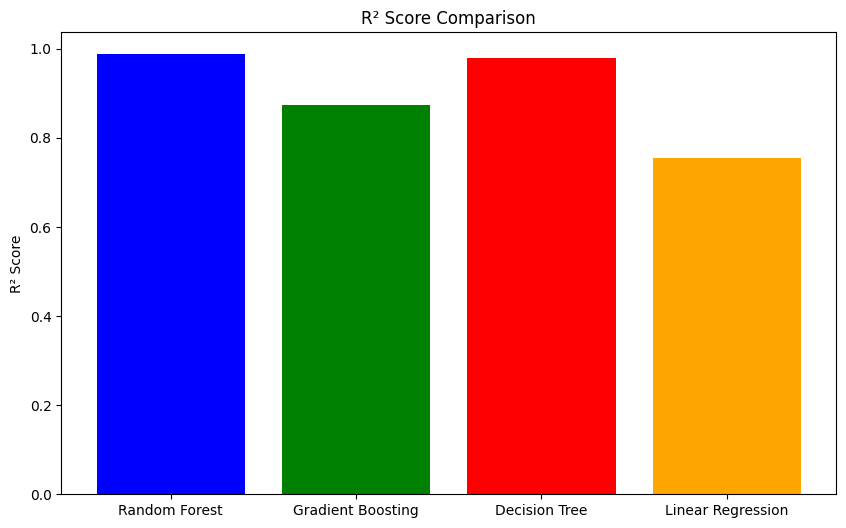

In [46]:
# Visualization

# Plot R² scores for each model
plt.figure(figsize=(10, 6))
plt.bar(model_scores.keys(), model_scores.values(), color=['blue', 'green', 'red', 'orange'])
plt.title('R² Score Comparison')
plt.ylabel('R² Score')
plt.show()

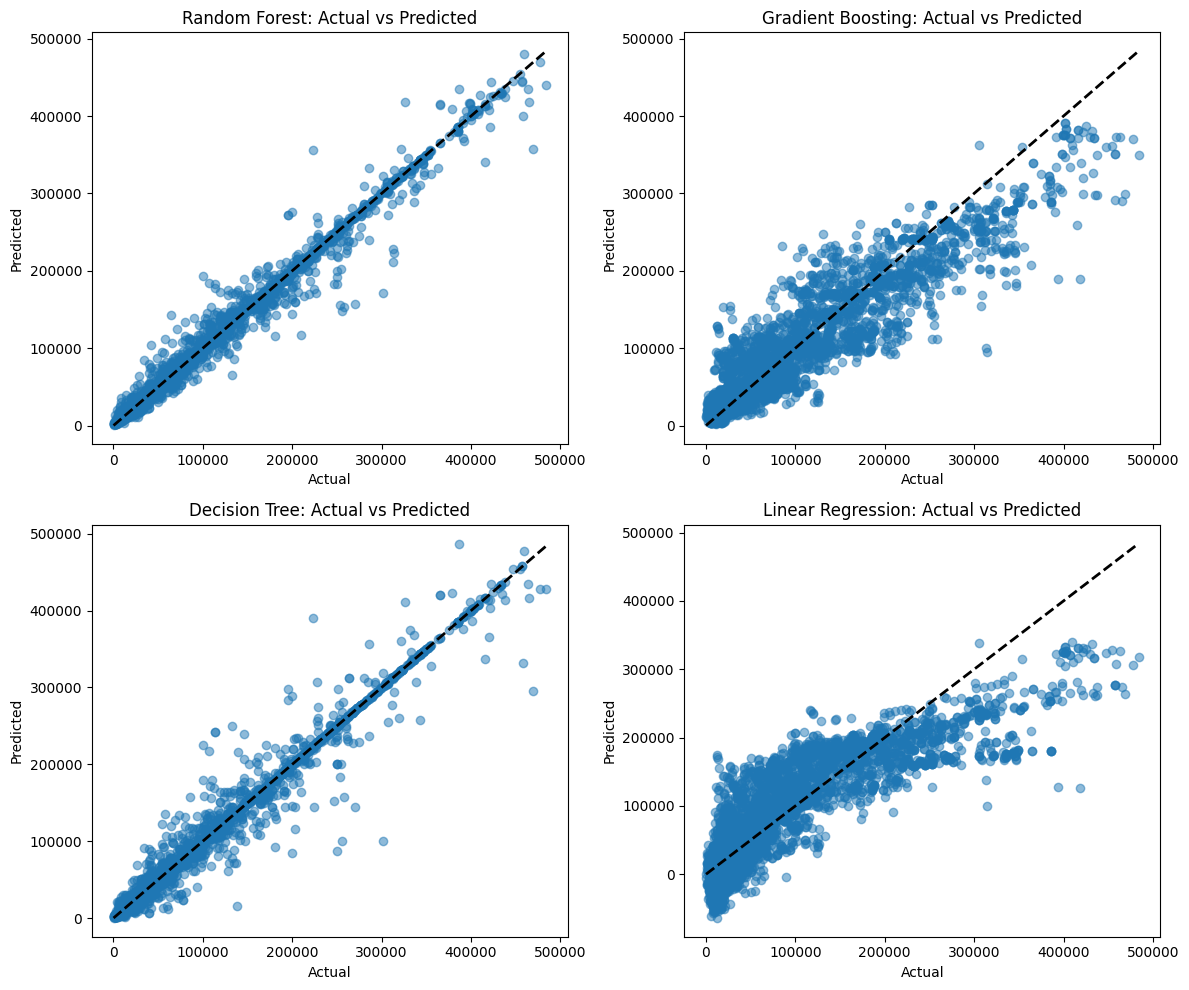

In [47]:
# Plot actual vs predicted for each model
plt.figure(figsize=(12, 10))
for i, (name, y_pred) in enumerate(predictions.items()):
    plt.subplot(2, 2, i + 1)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.title(f'{name}: Actual vs Predicted')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
plt.tight_layout()
plt.show()

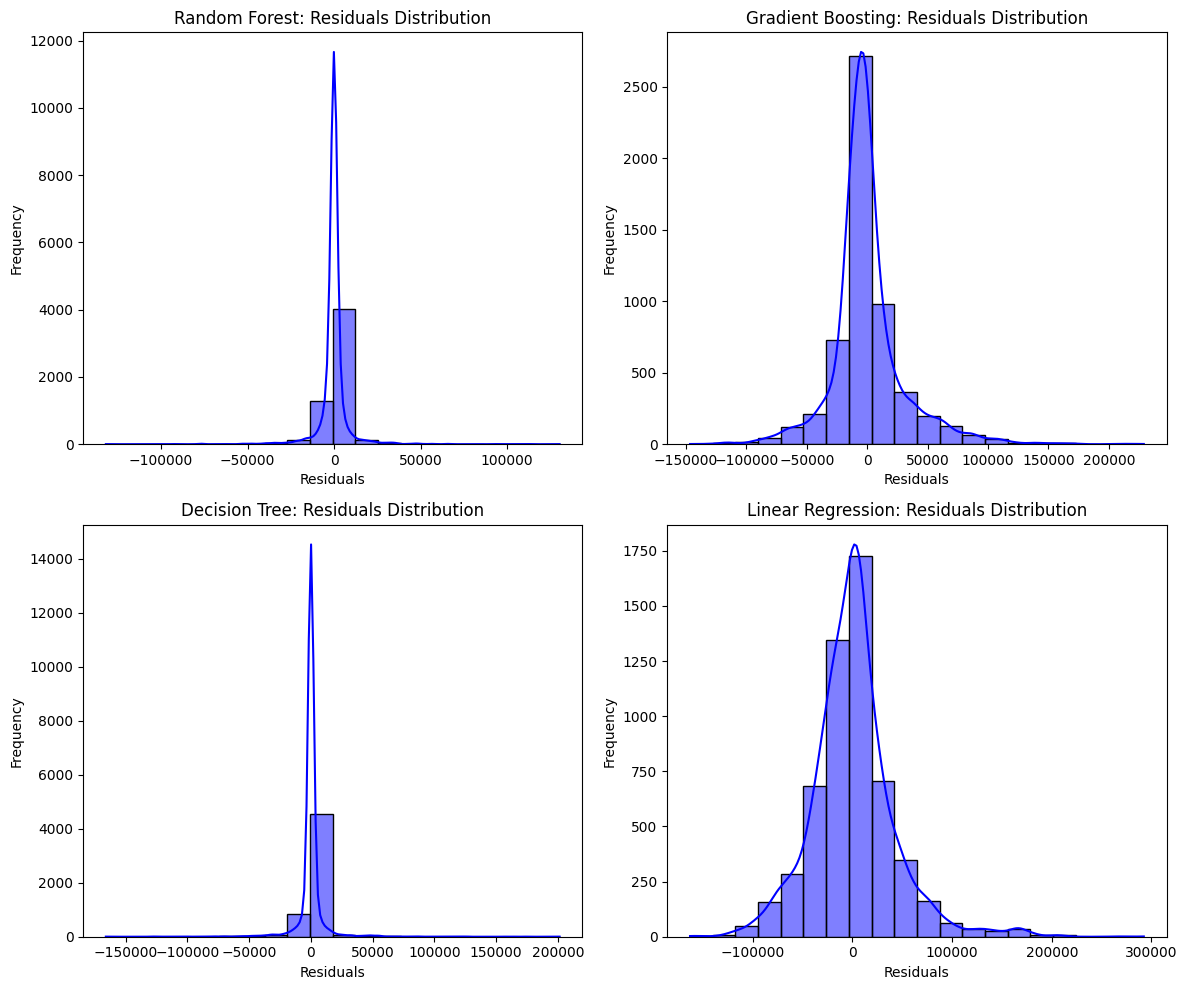

In [48]:
# Plot error distributions (residuals)
plt.figure(figsize=(12, 10))
for i, (name, y_pred) in enumerate(predictions.items()):
    plt.subplot(2, 2, i + 1)
    residuals = y_test - y_pred
    sns.histplot(residuals, bins=20, kde=True, color='blue')
    plt.title(f'{name}: Residuals Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Evaluating the Random Forest and Decision Tree, we can see that most distances are clustered around 0, however bins further from 0 are more spread out, meaning that at times the model has high outliers. On balance their performance is good, with most of the points near the diagonal in the actual vs predicted graphs.
Gradient Boosting again demonstrated very good performance, the residual distribution is slightly wider than in the previous two methods, predictions scatter a little more for higher levels.
Linear Regression performs the worst with the biggest spread of residuals and more dispersed predictions which, in general, illustrate that Linear Regression fails to fit complexities as well as tree based methods.


In [49]:
# Mean Squared Error
for name, y_pred in predictions.items():
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name} Mean Squared Error: {mse}")

Random Forest Mean Squared Error: 88661481.40422174
Gradient Boosting Mean Squared Error: 919466056.1923125
Decision Tree Mean Squared Error: 146960907.98601523
Linear Regression Mean Squared Error: 1776120651.072175
